In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define base directory where dataset is stored
base_dir = "/content/drive/MyDrive/cotton_aug"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


Mounted at /content/drive


In [ ]:
# Image size required for Xception model
IMG_SIZE = (299, 299)  # Xception requires 299x299 images
BATCH_SIZE = 32

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale validation and test images
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)


Found 1531 images belonging to 4 classes.
Found 214 images belonging to 4 classes.
Found 435 images belonging to 4 classes.
Classes: ['bacterial_blight', 'curl', 'fussarium_wilt', 'healthy']


In [ ]:
# Load pre-trained Xception model without top layers
base_model = Xception(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(class_names), activation="softmax")(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 608s 12s/step - accuracy: 0.3881 - loss: 1.2962 - val_accuracy: 0.7336 - val_loss: 0.9519
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 887ms/step - accuracy: 0.7028 - loss: 0.9211 - val_accuracy: 0.7664 - val_loss: 0.7760
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 897ms/step - accuracy: 0.7787 - loss: 0.7290 - val_accuracy: 0.8037 - val_loss: 0.6160
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 946ms/step - accuracy: 0.7892 - loss: 0.6391 - val_accuracy: 0.8271 - val_loss: 0.5313
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 904ms/step - accuracy: 0.8290 - loss: 0.5475 - val_accuracy: 0.8271 - val_loss: 0.4772
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 896ms/step - accuracy: 0.8454 - loss: 0.5030 - val_accuracy: 0.8785 - val_loss: 0.4214
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 975ms/step - accuracy: 0.8703 - loss: 0.4461 - val_accuracy: 0.8832 - val_loss: 0.3761
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 43s 896ms/step - accuracy: 0.8720 - loss: 0.4245 - val_accur

In [ ]:
model.save('/content/drive/MyDrive/aug_results/xception_model.keras')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict on test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


14/14 ━━━━━━━━━━━━━━━━━━━━ 167s 13s/step
                  precision    recall  f1-score   support

bacterial_blight       0.87      0.97      0.92       114
            curl       0.86      0.96      0.91       106
  fussarium_wilt       0.91      0.78      0.84       107
         healthy       0.91      0.83      0.87       108

        accuracy                           0.89       435
       macro avg       0.89      0.89      0.88       435
    weighted avg       0.89      0.89      0.89       435



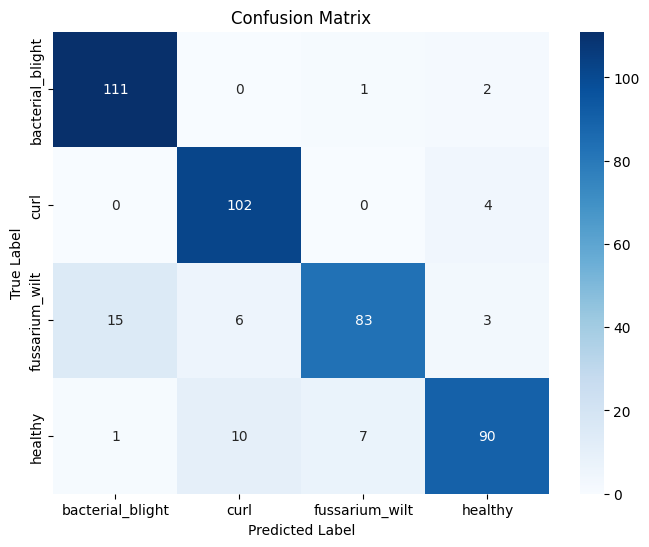

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


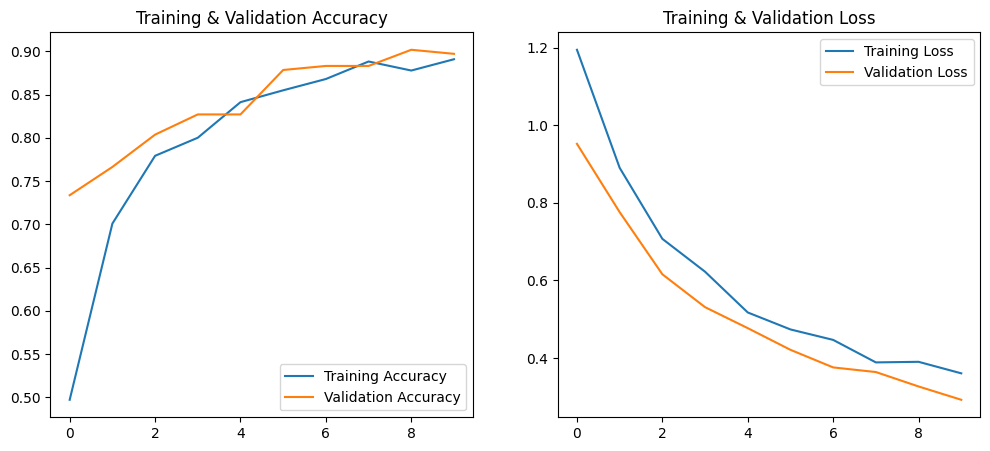

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training & Validation Loss")

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1198 images belonging to 4 classes.
Found 259 images belonging to 4 classes.
Found 255 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 369s 8s/step - accuracy: 0.4976 - loss: 1.1125 - val_accuracy: 0.6718 - val_loss: 3.0203
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 748ms/step - accuracy: 0.9172 - loss: 0.2676 - val_accuracy: 0.2548 - val_loss: 53.2369
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 724ms/step - accuracy: 0.8962 - loss: 0.3336 - val_accuracy: 0.6100 - val_loss: 7.8092
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 714ms/step - accuracy: 0.9722 - loss: 0.1042 - val_accuracy: 0.5598 - val_loss: 5.6032
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 724ms/step - accuracy: 0.9182 - loss: 0.2528 - val_accuracy: 0.5521 - val_loss: 7.5827
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 723ms/step - accuracy: 0.9739 - loss: 0.0784 - val_accuracy: 0.8417 - val_loss: 2.1930
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 732ms/step - accuracy: 0.9547 - loss: 0.2161 - val_accuracy: 0.8108 - val_loss: 1.5369
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 726ms/step - accuracy: 0.9721 - loss: 0.0849 - val_accur

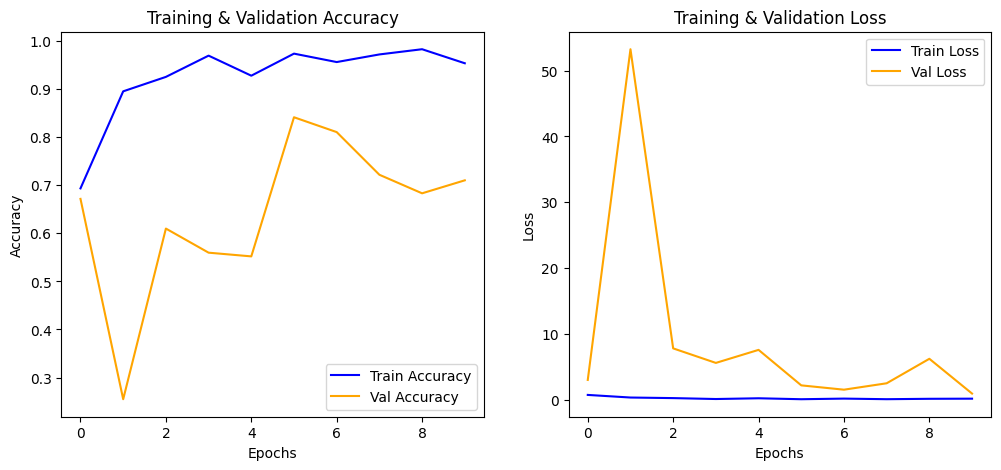

In [ ]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Step 2: Define Paths (CHANGE THIS IF NEEDED)
base_dir = "/content/drive/MyDrive/cotton_real"  # Path to 'cotton_real' folder
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# ✅ Step 3: Data Augmentation & Data Loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# ✅ Step 4: Load Pretrained Xception Model
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(4, activation='softmax')(x)  # 4 Classes: Bacterial Blight, Curl Virus, Fusarium Wilt, Healthy

model = Model(inputs=base_model.input, outputs=x)

# ✅ Step 5: Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Step 6: Train the Model
EPOCHS = 10
history = model.fit(
    train_generator, validation_data=val_generator, epochs=EPOCHS
)

# ✅ Step 7: Evaluate the Model on Test Set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute precision, recall, and F1-score
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# ✅ Step 8: Plot Accuracy & Loss Curves
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.show()


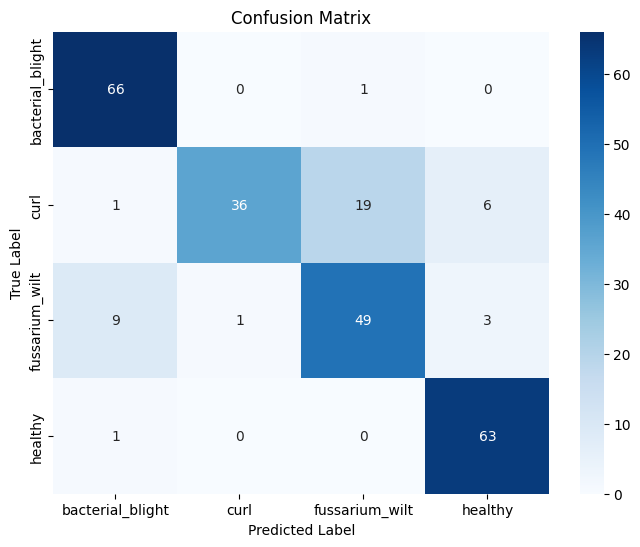

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

